loading with manual binary decoding... I think meshio is messing up. 

In [1]:
import os, yt, numpy as np, copy
import xmltodict
import numpy as np
import zlib
import base64

DataDir=os.path.join(os.environ.get('ASPECTdatadir','../'),'edc_driven_convection_madagascar',
                     'edc_driven_convection_madagascar','solution')

In [2]:
def decode_binary(blob, use_zlib = True, dtype="<f4"):
    split_location = blob.find(b"==") + 2
    first = base64.decodebytes(blob[:split_location])
    second = base64.decodebytes(blob[split_location:])
    if zlib:
        second = zlib.decompress(second)
    return np.frombuffer(first, dtype="<f4"), np.frombuffer(second, dtype=dtype)

In [3]:
def loadPiece(xmlPiece,fieldnames=[]):

    _, coords = decode_binary(xmlPiece["Points"]["DataArray"]["#text"].encode(),
                    dtype="<f8")
    _, conn = decode_binary(xmlPiece["Cells"]["DataArray"][0]["#text"].encode(),
                 dtype="u4")
    _, offsets = decode_binary(xmlPiece["Cells"]["DataArray"][1]["#text"].encode(),
                 dtype="u4")
    _, cell_types = decode_binary(xmlPiece["Cells"]["DataArray"][2]["#text"].encode(),
                 dtype="u1")
    
    data = {}
    for data_array in xmlPiece['PointData']['DataArray']:
        # get names of arrays
        names = data_array['@Name']
        if names!='velocity' and (len(fieldnames)==0 or names in fieldnames):
            types = data_array['@type']
            # get binary code (as string)
            text = data_array['#text']
            # re-encode string
            etext = text.encode()
            metadata, data_field = decode_binary(etext,dtype=np.float64)
            data[names] = data_field
        
    return coords,conn,offsets,cell_types, data 

In [4]:
def loadPieces(xmlPieces,fieldnames=[],fieldtype='connect1'):
    
    def dName(varname):
        return (fieldtype,varname)
    
    conns=[]
    alloffs=[]
    x=[]
    y=[]
    z=[]
    datadict={}
    pieceoff=0    
    for piece_id in range(0,len(xmlPieces)):           

        coords,conn,offsets,cell_types,data=loadPiece(xmlPieces[piece_id],fieldnames)         
        
        coords = coords.reshape((coords.size // 3, 3))                  
        x.extend(coords[:,0])
        y.extend(coords[:,1])
        z.extend(coords[:,2])

#         print(pieceoff)
#         print(offsets)
        print("\npiece ",piece_id)
        print('shp:',coords.shape[0])
        print('xshp:',len(x))
        print('consize',conn.size)
        print('consmax',conn.max())
        print('offset last',offsets[-1])
#         print(coords.max())
        conns.extend(conn+pieceoff)    
        pieceoff=pieceoff+conn.size
        alloffs.extend(offsets)        
        
        for var,vals in data.items():
            if dName(var) not in datadict.keys(): 
                datadict[dName(var)]=[]
            datadict[dName(var)].extend(vals)    

    coords=np.array(np.column_stack([x,y,z]))    
    alloffs=np.array(alloffs)
    conns=np.array(conns)
    conns = conns.reshape((conns.size // 8, 8))
    
    for var,vals in datadict.items():
        datadict[var]=np.reshape(np.array(datadict[var])[conns.ravel()],conns.shape)
        
    return coords,conns,alloffs,datadict

In [5]:
sFile=os.path.join(DataDir,'solution-00005.0000.vtu')
  

In [6]:
with open(sFile) as data:
    xml = xmltodict.parse(data.read())  
    
(coords,conns,alloffs,data)=loadPieces(xml['VTKFile']['UnstructuredGrid']['Piece'])



piece  0
shp: 17472
xshp: 17472
consize 17472
consmax 17471
offset last 17472

piece  1
shp: 17472
xshp: 34944
consize 17472
consmax 17471
offset last 17472

piece  2
shp: 17472
xshp: 52416
consize 17472
consmax 17471
offset last 17472

piece  3
shp: 17472
xshp: 69888
consize 17472
consmax 17471
offset last 17472

piece  4
shp: 17472
xshp: 87360
consize 17472
consmax 17471
offset last 17472

piece  5
shp: 17472
xshp: 104832
consize 17472
consmax 17471
offset last 17472

piece  6
shp: 17472
xshp: 122304
consize 17472
consmax 17471
offset last 17472

piece  7
shp: 17536
xshp: 139840
consize 17536
consmax 17535
offset last 17536


In [7]:
(coords,conn,offsets,cell_types, data )=loadPiece(xml['VTKFile']['UnstructuredGrid']['Piece'][-2])

coords.reshape(coords.size//3,3).shape

(17472, 3)

In [8]:
conns.shape

(17480, 8)

In [9]:
conns.size

139840

In [10]:
coords.shape

(52416,)

In [11]:
conns.max()

139839

The connectivity indexing issue is **NOT** there. Bug in `meshio` read???

**Now concatenate across pvu files**

In [12]:
pFile=os.path.join(DataDir,'solution-00005.pvtu')
with open(pFile) as data:
    pxml = xmltodict.parse(data.read())  

In [13]:
GlobalCons=[]
GlobalCoords=[]
GlobalDict={}


conn_offset=0
for pnum,piece in enumerate(pxml['VTKFile']['PUnstructuredGrid']['Piece']):
    print("processing piece ",pnum)
    pieceFile=os.path.join(DataDir,piece['@Source'])
    
    with open(pieceFile) as data:
        xml = xmltodict.parse(data.read())  

    (coords,conns,alloffs,data)=loadPieces(xml['VTKFile']['UnstructuredGrid']['Piece'])
    
    conns=conns+conn_offset 
    conn_offset=conn_offset+conns.size
    
    GlobalCons.extend(conns)
    GlobalCoords.extend(coords)
    
    for var,vals in data.items():
        if var not in GlobalDict.keys():
            GlobalDict[var]=[]            
        GlobalDict[var].extend(vals)
        
            
GlobalCons=np.array(GlobalCons).astype("i8")        
GlobalCoords=np.array(GlobalCoords).astype("f8")        
for var,vals in GlobalDict.items():    
    GlobalDict[var]=np.array(GlobalDict[var]).astype("f8")
    
    

processing piece  0

piece  0
shp: 17472
xshp: 17472
consize 17472
consmax 17471
offset last 17472

piece  1
shp: 17472
xshp: 34944
consize 17472
consmax 17471
offset last 17472

piece  2
shp: 17472
xshp: 52416
consize 17472
consmax 17471
offset last 17472

piece  3
shp: 17472
xshp: 69888
consize 17472
consmax 17471
offset last 17472

piece  4
shp: 17472
xshp: 87360
consize 17472
consmax 17471
offset last 17472

piece  5
shp: 17472
xshp: 104832
consize 17472
consmax 17471
offset last 17472

piece  6
shp: 17472
xshp: 122304
consize 17472
consmax 17471
offset last 17472

piece  7
shp: 17536
xshp: 139840
consize 17536
consmax 17535
offset last 17536
processing piece  1

piece  0
shp: 17472
xshp: 17472
consize 17472
consmax 17471
offset last 17472

piece  1
shp: 17472
xshp: 34944
consize 17472
consmax 17471
offset last 17472

piece  2
shp: 17472
xshp: 52416
consize 17472
consmax 17471
offset last 17472

piece  3
shp: 17472
xshp: 69888
consize 17472
consmax 17471
offset last 17472

piece  4

processing piece  14

piece  0
shp: 17472
xshp: 17472
consize 17472
consmax 17471
offset last 17472

piece  1
shp: 17472
xshp: 34944
consize 17472
consmax 17471
offset last 17472

piece  2
shp: 17472
xshp: 52416
consize 17472
consmax 17471
offset last 17472

piece  3
shp: 17472
xshp: 69888
consize 17472
consmax 17471
offset last 17472

piece  4
shp: 17472
xshp: 87360
consize 17472
consmax 17471
offset last 17472

piece  5
shp: 17472
xshp: 104832
consize 17472
consmax 17471
offset last 17472

piece  6
shp: 17472
xshp: 122304
consize 17472
consmax 17471
offset last 17472
processing piece  15

piece  0
shp: 17472
xshp: 17472
consize 17472
consmax 17471
offset last 17472

piece  1
shp: 17472
xshp: 34944
consize 17472
consmax 17471
offset last 17472

piece  2
shp: 17472
xshp: 52416
consize 17472
consmax 17471
offset last 17472

piece  3
shp: 17472
xshp: 69888
consize 17472
consmax 17471
offset last 17472

piece  4
shp: 17472
xshp: 87360
consize 17472
consmax 17471
offset last 17472

piece  

In [14]:
GlobalCons.shape

(262144, 8)

In [15]:
GlobalCons.size

2097152

In [16]:
GlobalCoords.shape

(2097152, 3)

In [17]:
GlobalDict[('connect1','T')].shape

(262144, 8)

In [18]:
ds = yt.load_unstructured_mesh(
    GlobalCons,
    GlobalCoords,
    node_data = GlobalDict
)  
ds.fluid_types += ('index',)

yt : [INFO     ] 2020-07-02 10:38:08,358 Parameters: current_time              = 0.0
yt : [INFO     ] 2020-07-02 10:38:08,359 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2020-07-02 10:38:08,359 Parameters: domain_left_edge          = [ 2679220.40116885  2679220.40116884 -3272029.00399254]
yt : [INFO     ] 2020-07-02 10:38:08,362 Parameters: domain_right_edge         = [5653600.91489411 5653600.91489411 -736270.69874229]
yt : [INFO     ] 2020-07-02 10:38:08,363 Parameters: cosmological_simulation   = 0.0


yt : [INFO     ] 2020-07-02 10:38:08,572 xlim = 2679220.401169 5653600.914894
yt : [INFO     ] 2020-07-02 10:38:08,572 ylim = 2679220.401169 5653600.914894
yt : [INFO     ] 2020-07-02 10:38:08,573 xlim = 2679220.401169 5653600.914894
yt : [INFO     ] 2020-07-02 10:38:08,573 ylim = 2679220.401169 5653600.914894
yt : [INFO     ] 2020-07-02 10:38:08,576 Making a fixed resolution buffer of (('connect1', 'velocity_inclination')) 800 by 800
yt : [WARNING  ] 2020-07-02 10:38:08,861 Plot image for field ('connect1', 'velocity_inclination') has both positive and negative values. Min = -88.544407, Max = 89.216976.
yt : [WARNING  ] 2020-07-02 10:38:08,862 Switching to symlog colorbar scaling unless linear scaling is specified later
/home/chavlin/src/yt/yt/visualization/base_plot_types.py:205: MatplotlibDeprecationWarning: default base may change from np.e to 10.  To suppress this warning specify the base keyword argument.
  norm = matplotlib.colors.SymLogNorm(



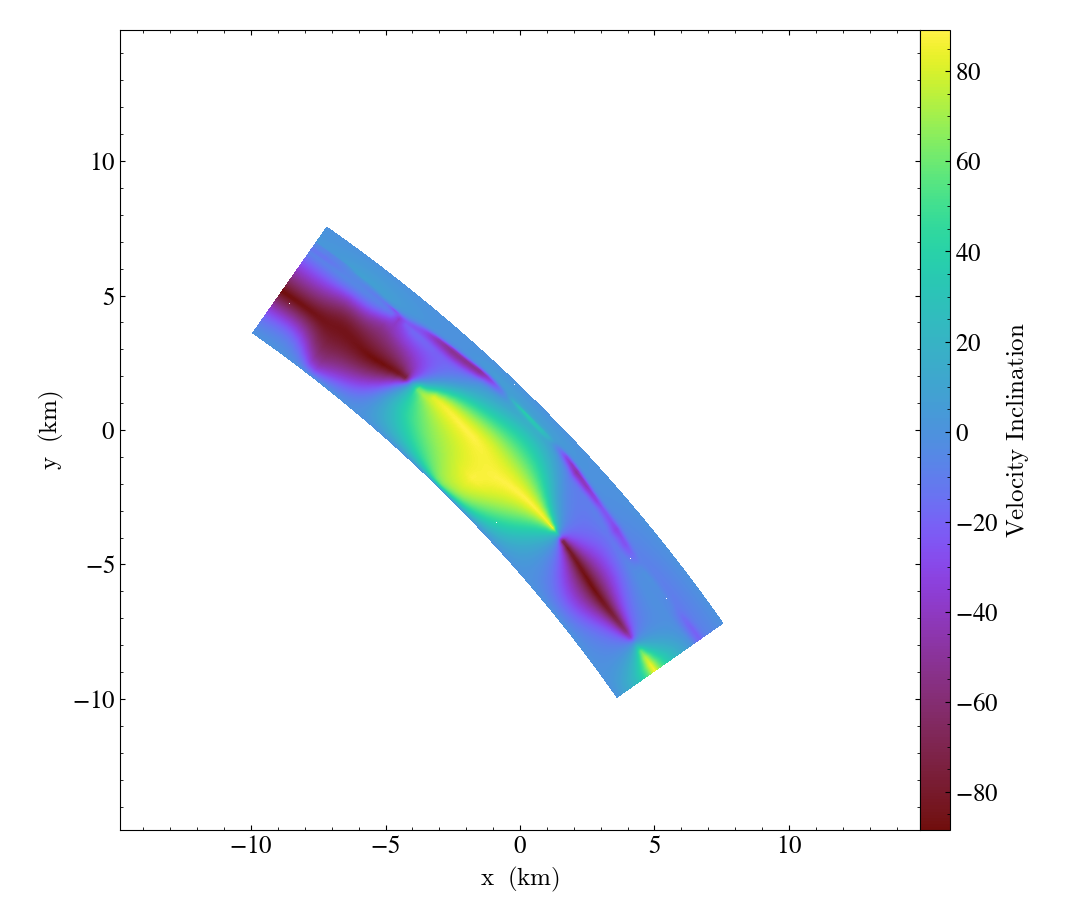

In [19]:
p=yt.SlicePlot(ds, "z", ("connect1", "velocity_inclination"))
p.set_log("velocity_inclination",False)
p.show()